# Pré traitement des données

## I. Conversion C3D en JSON rééchantilloné à 50 Hz

In [1]:
import numpy as np
import ezc3d
import json
from scipy.signal import resample,butter, lfilter, freqz
import matplotlib.pyplot as plt
import pandas as pd

In [15]:
def recuperer_evenements(file_path):
    """
    Cette fonction extrait les événements du fichier C3D.

    Args:
        file_path (str): Le chemin du fichier C3D.

    Returns:
        dict: Un dictionnaire contenant les événements et leur temps correspondant.
    """
    c3d = ezc3d.c3d(file_path)
    events = c3d['parameters']['EVENT']['LABELS']['value'] # Récupérer les événements
    temps_events = c3d['parameters']['EVENT']['TIMES']['value'] # Récupérer les temps correspondant aux événements
    # Créer un DataFrame
    df = pd.DataFrame({'events': events, 'frames': temps_events[1]})
    # Supprimer l'index
    df.reset_index(drop=True, inplace=True)
    events_dict = df.groupby('events')['frames'].apply(list).to_dict()
    return events_dict

def butter_lowpass(cutoff, fs, order=5):
    """
    Crée les coefficients d'un filtre Butterworth passe-bas.

    Args:
        cutoff (float): Fréquence de coupure du filtre.
        fs (float): Fréquence d'échantillonnage du signal.
        order (int): Ordre du filtre.

    Returns:
        tuple: Coefficients du filtre (b, a).
    """
    nyq = 0.5 * fs # Fréquence de Nyquist
    normal_cutoff = cutoff / nyq # Fréquence de coupure normalisée
    b, a = butter(order, normal_cutoff, btype='low', analog=False) # Création des coefficients du filtre
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    """
    Applique un filtre Butterworth passe-bas à un signal.

    Args:
        data (array_like): Signal à filtrer.
        cutoff (float): Fréquence de coupure du filtre.
        fs (float): Fréquence d'échantillonnage du signal.
        order (int): Ordre du filtre.

    Returns:
        array_like: Signal filtré.
    """
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def reechantillonnage_fc_coupure_et_association_labels_et_data(file_path, cutoff_freq=20, target_freq=50):
    """
    Cette fonction transforme les données échantillonnées à 2100 Hz en données échantillonnées à 50 Hz,
    puis applique un filtre Butterworth passe-bas avec une fréquence de coupure de 20 Hz, et enfin associe les étiquettes des données aux données rééchantillonnées et filtrées.

    Args:
        file_path (str): Le chemin du fichier C3D.
        cutoff_freq (float): Fréquence de coupure du filtre Butterworth (20 Hz).
        target_freq (float): Fréquence cible après rééchantillonnage (50 Hz).

    Returns:
        tuple: Un tuple contenant un dictionnaire fusionnant les étiquettes et les données rééchantillonnées et filtrées, et les temps rééchantillonnés.
    """
    c3d = ezc3d.c3d(file_path)
    labels = c3d['parameters']['ANALOG']['LABELS']['value'] # Récupérer les étiquettes des données
    original_freq = c3d['parameters']['ANALOG']['RATE']['value'][0] # Récupérer la fréquence d'échantillonnage
    data = c3d['data']['analogs'] # Récupérer les données
    nb_frame = len(data[0][0]) # Récupérer le nombre de frames
    target_freq = 50  # fréquence de rééchantillonnage
    
    # Rééchantillonnage des données
    nb_samples_target = int(nb_frame * (target_freq / original_freq)) # Calcul du nombre d'échantillons cible
    resampled_times = np.linspace(0., (nb_frame / original_freq), num=nb_samples_target) # Création d'un tableau de temps rééchantillonné
    resampled_data = np.zeros((len(labels), nb_samples_target)) # Création d'un tableau de zéros de la taille des données rééchantillonnées
    for i in range(len(labels)): # Pour chaque étiquette
        resampled_data[i, :] = resample(data[0][i, :], nb_samples_target) # Rééchantillonnage des données

    fusion_label_data = {}
    for i, label in enumerate(labels): # Pour chaque étiquette
        fusion_label_data[label] = resampled_data[i, :] # Associer les étiquettes aux données rééchantillonnées
        
    # Filtrage des données rééchantillonnées
    filtered_data = np.zeros_like(resampled_data) # Création d'un tableau de zéros de la même taille que les données rééchantillonnées
    for i in range(len(labels)): # Pour chaque étiquette
        filtered_data[i, :] = butter_lowpass_filter(resampled_data[i, :], cutoff_freq, target_freq) # Appliquer un filtre passe-bas

    fusion_label_data = {}
    for i, label in enumerate(labels): 
        fusion_label_data[label] = filtered_data[i, :] # Associer les étiquettes aux données filtrées
    
    return fusion_label_data, resampled_times
    

def filtrer_labels(fusion_label_data):
    """
    Cette fonction filtre les étiquettes des données pour ne garder que celles liées à l'accéléromètre et au gyroscope.

    Args:
        fusion_label_data (dict): Dictionnaire contenant les étiquettes et les données associées.

    Returns:
        tuple: Un tuple contenant une liste des étiquettes filtrées et un dictionnaire des données associées aux étiquettes filtrées.
    """
    labels_filtre = []
    labels_data_filtre = {}
    for label, valeurs in fusion_label_data.items(): # Pour chaque étiquette et ses valeurs
        if 'ACC' in label or 'GYRO' in label: # Si l'étiquette contient 'ACC' ou 'GYRO'
            labels_filtre.append(label) # Ajouter l'étiquette à la liste des étiquettes filtrées
            labels_data_filtre[label] = valeurs # Ajouter les valeurs associées à l'étiquette dans le dictionnaire des données filtrées
    return labels_filtre, labels_data_filtre

def calcul_norme(labels_data_filtre):
    """
    Cette fonction calcule les normes des données filtrées.

    Args:
        labels_data_filtre (dict): Dictionnaire contenant les étiquettes et les données associées, filtrées.

    Returns:
        dict: Un dictionnaire contenant les normes calculées.
    """
    normes = {}
    traite = set() # Créer un ensemble vide pour stocker les capteurs, les côtés et les mesures déjà traités
    for key, value in labels_data_filtre.items():
        parts = key.split('_') # Séparer l'étiquette en parties
        sensor = parts[0] # Récupérer le capteur
        side = parts[1] # Récupérer le côté
        measure = parts[2] # Récupérer la mesure (GYRO ou ACC)
        
        if (sensor, side, measure) not in traite: # Si le capteur, le côté et la mesure n'ont pas déjà été traités
            traite.add((sensor, side, measure)) # Ajouter le capteur, le côté et la mesure à l'ensemble des éléments traités
            
            if "ACC" in measure:
                # Obtention des axes X, Y et Z
                axe_X = (labels_data_filtre[f'{sensor}_{side}_{measure}_X'])*9.8
                axe_Y = (labels_data_filtre[f'{sensor}_{side}_{measure}_Y'])*9.8
                axe_Z = (labels_data_filtre[f'{sensor}_{side}_{measure}_Z'])*9.8
            
                norme = np.sqrt(axe_X**2 + axe_Y**2 + axe_Z**2) - 9.8 # Calcul de la norme auquelle on soustrait 1 pour enlever la gravité
                nom_cle = f'{sensor}_{side}_{measure}_norme'
                normes[nom_cle] = norme
                
            else:
                axe_X = labels_data_filtre[f'{sensor}_{side}_{measure}_X']
                axe_Y = labels_data_filtre[f'{sensor}_{side}_{measure}_Y']
                axe_Z = labels_data_filtre[f'{sensor}_{side}_{measure}_Z']
        
                norme = np.sqrt(axe_X**2 + axe_Y**2 + axe_Z**2) 
                nom_cle = f'{sensor}_{side}_{measure}_norme'
                normes[nom_cle] = norme

    return normes

def creer_structure_json(labels_data_filtre, patient_id, date_de_naissance, medicaments, resampled_times, events_dict, normes):
    """
    Cette fonction crée une structure JSON à partir des données filtrées et d'autres informations.

    Args:
        labels_data_filtre (dict): Dictionnaire contenant les étiquettes et les données associées, filtrées.
        patient_id (int): Identifiant du patient.
        date_de_naissance (str): Date de naissance du patient.
        medicaments (str): Médicaments pris par le patient.
        resampled_times (ndarray): Temps rééchantillonné.
        events_dict (dict): Dictionnaire contenant les événements et leur temps correspondant.
        normes (dict): Dictionnaire contenant les normes calculées.

    Returns:
        dict: Structure JSON contenant les données et les métadonnées.
    """
    json_data = {
        "metadata": {
            "Détails du patient": {
                "Identifiant": patient_id,
                "Date de naissance": date_de_naissance,
                "Medicaments": medicaments
            },
            "Temps": resampled_times.tolist()
        }
    }
    
    for key, value in labels_data_filtre.items():
        parts = key.split('_')
        sensor = parts[1]
        side = parts[0]
        measure = parts[2]
        axis = parts[3]
        
        if sensor not in json_data:
            json_data[sensor] = {}

        if side not in json_data[sensor]:
            json_data[sensor][side] = {}

        if measure not in json_data[sensor][side]:
            json_data[sensor][side][measure] = {}

        json_data[sensor][side][measure][axis] = value.tolist()
        
    for key in normes:
        parts = key.split('_')
        sensor = parts[1]
        side = parts[0]
        measure = parts[2]
        axis = parts[3]

        if sensor not in json_data:
            json_data[sensor] = {}

        if side not in json_data[sensor]:
            json_data[sensor][side] = {}

        if measure not in json_data[sensor][side]:
            json_data[sensor][side][measure] = {}

        # Insérer la norme au même niveau d'indentation que l'axe
        json_data[sensor][side][measure][axis] = value.tolist()
        json_data[sensor][side][measure]["norme"] = normes[key].tolist()
    
    # Ajouter les événements FOG
    json_data["FOG"] = {
        "Debut": events_dict["FOG_begin"],
        "Fin": events_dict["FOG_end"]
    }
    
    # Ajouter tous les évènements sauf FOG
    del events_dict["FOG_begin"]
    del events_dict["FOG_end"]
    
    json_data["Parcours"] = events_dict
    
    return json_data

def creation_json_grace_c3d(file_path, patient_id, date_de_naissance, medicaments, output_path):
    """
    Cette fonction crée un fichier JSON à partir d'un fichier C3D.

    Args:
        file_path (str): Le chemin du fichier C3D.
        patient_id (int): Identifiant du patient.
        date_de_naissance (str): Date de naissance du patient.
        medicaments (str): Médicaments pris par le patient.
        output_path (str): Le chemin de sortie du fichier JSON.
    """
    events_dict = recuperer_evenements(file_path) 
    fusion_label_data, resampled_times = reechantillonnage_fc_coupure_et_association_labels_et_data(file_path)
    labels_filtre, labels_data_filtre = filtrer_labels(fusion_label_data)
    normes = calcul_norme(labels_data_filtre)
    json_structure = creer_structure_json(labels_data_filtre, patient_id, date_de_naissance, medicaments, resampled_times, events_dict, normes)
    
    with open(output_path, "w") as fichier_json:
        json.dump(json_structure, fichier_json, indent=4)

# Utilisation de la fonction pour traiter le fichier C3D et générer le fichier JSON
fichier_brut = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATA_FOG/LE_LIEVRE_Emmanuel_1971_03_19_LEEM1971/2023-05-26/2023-05-26_overlay_detectFOG/Video overlay 16 - Anthony.c3d"
fichier_brut = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATA_FOG/MORETTY_Daniel_1963-06-23_MODA1963/2023-07-07/2023-07-07_overlay_unspecified/Video overlay 1.c3d"
fichier_brut_16 = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATA_FOG/LE_LIEVRE_Emmanuel_1971_03_19_LEEM1971/2023-05-26/2023-05-26_overlay_detectFOG/Video overlay 16 update.c3d"

patient_id = 1234
date_de_naissance = 45
medicaments = "ON"
chemin_fichier_json_16_update = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATABASE/Video overlay 16 - update.json"
chemin__fichier_json = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATABASE/Video overlay 1.json"
creation_json_grace_c3d(fichier_brut_16, patient_id, date_de_naissance, medicaments, chemin_fichier_json_16_update)


In [2]:
chemin_fichier_json_16 = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATABASE/Video overlay 16.json"
chemin_fichier_json_anthony = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATABASE/Video overlay 16 - Anthony.json"
chemin_fichier_json_16_update = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATABASE/Video overlay 16 - update.json"
chemin_fichier_json_1 = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATABASE/Video overlay 1.json"

# Charger le fichier JSON
with open(chemin_fichier_json_16, "r") as fichier_json:
    donnees_patient_16 = json.load(fichier_json)
    
with open(chemin_fichier_json_anthony, "r") as fichier_json:
    donnees_patient_anthony = json.load(fichier_json) 
    
with open(chemin_fichier_json_1, "r") as fichier_json:
    donnees_patient_1 = json.load(fichier_json)   

with open(chemin_fichier_json_16_update, "r") as fichier_json:
    donnees_patient_16_update = json.load(fichier_json)   

# Accéder aux données spécifiques
#temps = donnees_patient["Rectus Femoris"]["Left"]["ACC"]["norme"]
temps_16 = donnees_patient_16["metadata"]["Temps"]
Norme_GYRO_tibia_16 = donnees_patient_16["Tibialis Anterior"]["Left"]["GYRO"]["norme"]
FOG_overlay_16 = donnees_patient_16["FOG"]
parcours_16 = donnees_patient_16["Parcours"]

temps_anthony = donnees_patient_anthony["metadata"]["Temps"]
Norme_GYRO_tibia_anthony = donnees_patient_anthony["Tibialis Anterior"]["Left"]["GYRO"]["norme"]
Norme_GYRO_tibia_anthony_X = donnees_patient_anthony["Tibialis Anterior"]["Left"]["GYRO"]["X"]

FOG_overlay_anthony = donnees_patient_anthony["FOG"]
parcours_anthony = donnees_patient_anthony["Parcours"]

#Patient 16 update
temps_16_update = donnees_patient_16_update["metadata"]["Temps"]
Norme_GYRO_tibia_16_update = donnees_patient_16_update["Tibialis Anterior"]["Left"]["GYRO"]["norme"]
Norme_GYRO_tibia_anthony_16_update = donnees_patient_16_update["Tibialis Anterior"]["Left"]["GYRO"]["X"]


## Comparaison visuelle des évènements de FOG labellisés par deux neurologues

In [2]:
def plot_comparison_with_events(time, signal, nom_evaluateur_1, fog_events_1, nom_evaluateur_2, fog_events_2):
    """
    Cette fonction permet de comparer les événements de FOG renseignés entre deux neurologues sur un signal donné.
    Args:
        time (array_like): Vecteur de temps.
        signal (array_like): Signal à tracer.
        fog_events_1 (dict): Dictionnaire contenant les instants des événements FOG évalués par le premier neurologue.
        fog_events_2 (dict): Dictionnaire contenant les instants des événements FOG pour le deuxième neurologue.
    """
    def plot_events_vertical_lines(events, color, linestyle, label):
        for event in events:
            plt.axvline(x=event, color=color, linestyle=linestyle, label=label)

    events_1_begin = fog_events_1.get("Debut", [])
    events_1_end = fog_events_1.get("Fin", [])
    events_2_begin = fog_events_2.get("Debut", [])
    events_2_end = fog_events_2.get("Fin", [])

    indices_1_begin = np.searchsorted(time, events_1_begin)
    indices_1_end = np.searchsorted(time, events_1_end)
    indices_2_begin = np.searchsorted(time, events_2_begin)
    indices_2_end = np.searchsorted(time, events_2_end)

    plt.figure(figsize=(12, 6))

    plt.plot(time, signal)

    plot_events_vertical_lines(events_1_begin, 'green', '--', f'FOG_begin - {nom_evaluateur_1}')
    plot_events_vertical_lines(events_1_end, 'red', '--', f'FOG_end - {nom_evaluateur_1}')

    plot_events_vertical_lines(events_2_begin, 'green', ':', f'FOG_begin - {nom_evaluateur_2}')
    plot_events_vertical_lines(events_2_end, 'red', ':', f'FOG_end - {nom_evaluateur_2}')

    plt.xlabel('Temps (s)')
    plt.ylabel('°/s')
    #plt.title(f"Signal provenant de l'axe X du gyroscope de la cuisse gauche")
    plt.title(f'Comparaison des évènements de FOG entre {nom_evaluateur_1} et {nom_evaluateur_2} sur le signal du gyroscope du tibia')

    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = []
    unique_handles = []
    for i, label in enumerate(labels):
        if label not in unique_labels:
            unique_labels.append(label)
            unique_handles.append(handles[i])
    plt.legend(unique_handles, unique_labels)

    line_diff_begin = abs(indices_1_begin - indices_2_begin)
    line_diff_end = abs(indices_1_end - indices_2_end)

    plt.text(0.5, -0.01, f'Écart de ligne :\n - FOG_Begin: {line_diff_begin}\n - FOG_End: {line_diff_end}', transform=plt.gcf().transFigure, va='center', ha='center')

    plt.tight_layout()  # Ajout pour ajuster automatiquement les positions des sous-graphiques et des légendes
    plt.show()


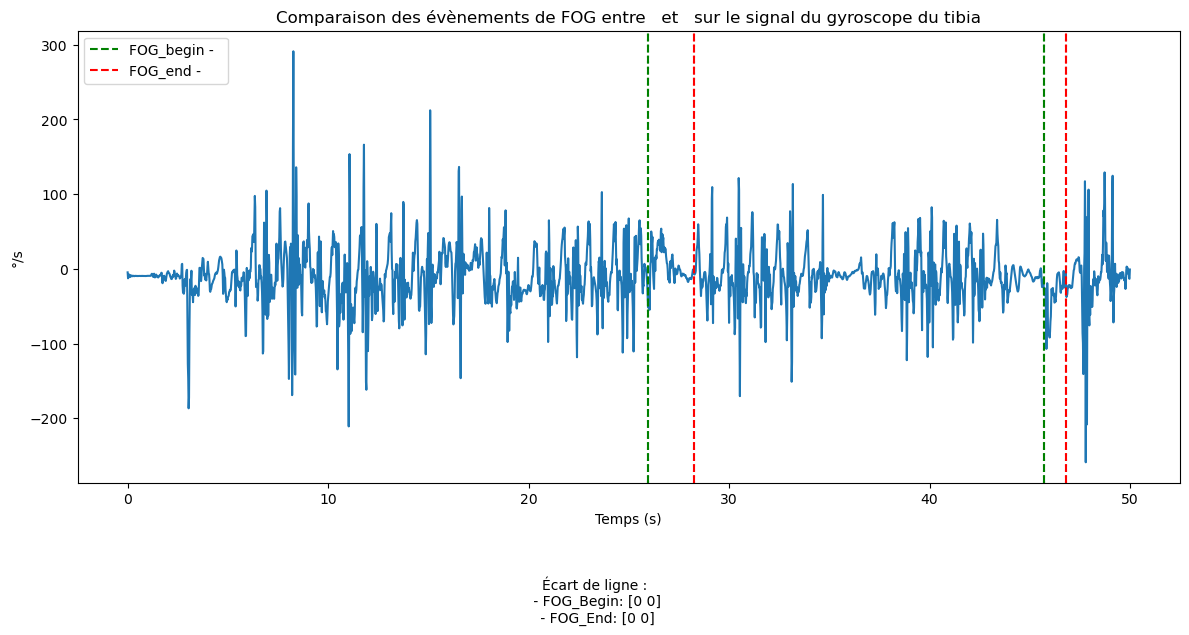

In [5]:
plot_comparison_with_events(temps_16, donnees_patient_16["Tibialis Anterior"]["Left"]["GYRO"]["X"], " ", FOG_overlay_16, " ",FOG_overlay_16)

In [6]:
def plot_inertial_data(data, muscle, side, sensor_type, axis, norme, temps):
    """
    Plot inertial data from a patient.
    
    Parameters:
        data (dict): Dictionary containing the patient's inertial data.
        sensor_type (str): Type of sensor data (e.g., "GYRO" or "ACC").
        muscle (str): Muscle name (e.g., "Tibialis Anterior").
        side (str): Side of the patient (e.g., "Left" or "Right").
        axis (str): Axis of the sensor data (e.g., "x", "y", or "z").
        norme (bool): Whether to plot the norme data or not.
        temps (list): List of time values.
    """
    if norme:
        data_to_plot = data[muscle][side][sensor_type]["norme"]
        title = f"{muscle} - {side} - {sensor_type} Norme"
    else:
        data_to_plot = data[muscle][side][sensor_type][axis]
        title = f"{muscle} - {side} - {sensor_type} - {axis}"

    plt.figure(figsize=(12, 6))
    plt.plot(temps, data_to_plot)
    plt.title(title)
    plt.xlabel("Temps")
    plt.ylabel("Valeurs") 
    plt.grid(True)
    plt.show()

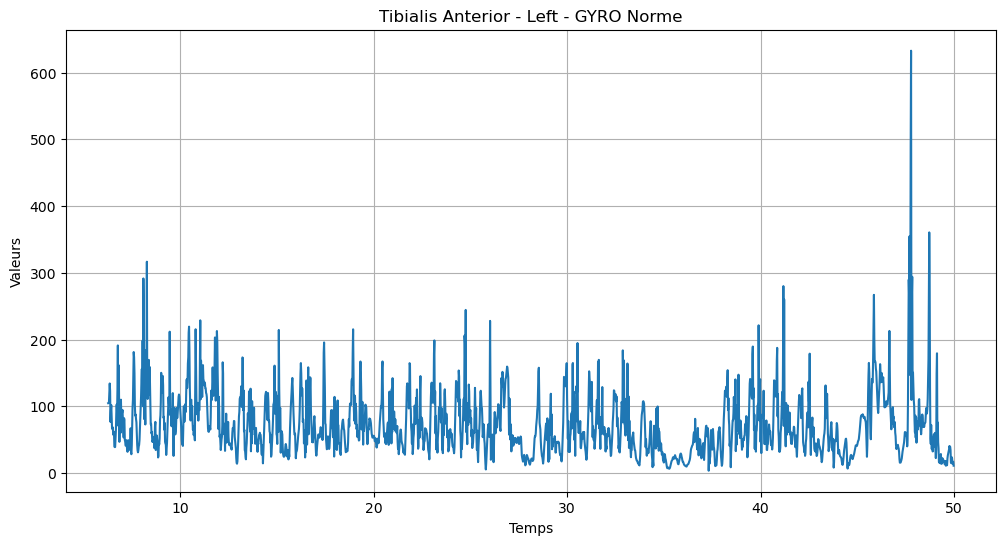

In [14]:
plot_inertial_data(donnees_patient_16, "Tibialis Anterior", "Left","GYRO", "norme", True, donnees_patient_16["metadata"]["Temps"])

## Normaliser les données

Attention : pour les patients détectFOG il ne faudra pas oublier d'enlever la partie assise, avant de normaliser

### On crée un seuil sur l'axe de la norme du GYRO = 250

In [3]:
from scipy.signal import find_peaks

In [15]:
def filtrer_donnees(donnees, seuil=250):
    """
    Filtrer les données d'un dictionnaire en fonction des pics détectés dans un muscle de référence.
    
    Args:
        donnees (dict): Le dictionnaire contenant les données.
        muscle_ref (str): Le nom du muscle de référence pour lequel les pics sont détectés.
        seuil (float): Le seuil utilisé pour détecter les pics dans les données du muscle de référence.
    
    Returns:
        dict: Un nouveau dictionnaire avec les données filtrées.
    """
    # Copier le dictionnaire pour ne pas modifier l'original
    nouveau_dictionnaire = donnees.copy()
    
    # Trouver les pics dans les données du muscle de référence
    muscle_data = donnees["Rectus Femoris"]["Left"]["GYRO"]["norme"]
    if muscle_data is None:
        raise ValueError("Muscle de référence non trouvé dans le dictionnaire de données.")
    
    peak_index, _ = find_peaks(muscle_data, height=seuil)
    if len(peak_index) == 0:
        print("Aucun pic trouvé dans les données du muscle de référence.")
        return nouveau_dictionnaire
    
    # Récupérer l'indice du premier pic
    premier_pic = peak_index[0]
    
    # Filtrer également les données de temps
    temps = donnees["metadata"]["Temps"][premier_pic:]

    # Muscles à extraire (à modifier selon vos besoins)
    muscles_a_extraire = ["Rectus Femoris","Tibialis Anterior", "Semitendinosus", "Vastus Lateralis"]

    # Remplacer les anciennes valeurs par les nouvelles
    for muscle in muscles_a_extraire:
        if muscle in nouveau_dictionnaire:
            for side in nouveau_dictionnaire[muscle].keys():
                for sensor in nouveau_dictionnaire[muscle][side].keys():
                    for axis in nouveau_dictionnaire[muscle][side][sensor].keys():
                        # Appliquer l'indice du premier pic aux autres muscles
                        nouveau_dictionnaire[muscle][side][sensor][axis] = donnees[muscle][side][sensor][axis][premier_pic:]
    
    # Remplacer les anciennes valeurs de temps par les nouvelles
    nouveau_dictionnaire["metadata"]["Temps"] = temps
    
    return nouveau_dictionnaire

# Exemple d'utilisation :
nouveau_dictionnaire = filtrer_donnees(donnees_patient_16)


In [18]:
a = nouveau_dictionnaire["Tibialis Anterior"]["Left"]["GYRO"]["Y"]
b = nouveau_dictionnaire["metadata"]["Temps"]

### Réduire les datas avec START et STOP pour avoir uniquement la position debout

In [7]:
def extract_axes_data_interval(data):
    # Extraire les temps de début et de fin du parcours
    start_time = data["Parcours"]["START"][0]
    end_time = data["Parcours"]["END"][0]
    epsilon=0.01

    # Trouver les indices correspondants dans le vecteur de temps pour le début du parcours
    for i, time in enumerate(data["metadata"]["Temps"]):
        if abs(time - start_time) < epsilon:  # Vérifier si la différence est inférieure à la marge d'erreur
            start_index = i
        if abs(time - end_time) < epsilon:
            end_index = i

    # Extraire les données d'axes pour la plage de temps START à END
    data_interval = {}
    for sensor, sensor_data in data.items():
        if sensor not in ["metadata", "Parcours", "FOG"]:
            data_interval[sensor] = {}
            for side, side_data in sensor_data.items():
                data_interval[sensor][side] = {}
                for measure, measure_data in side_data.items():
                    data_interval[sensor][side][measure] = {}
                    for axis, axis_data in measure_data.items():
                        data_interval[sensor][side][measure][axis] = axis_data[start_index:end_index+1]
                    # Ajouter les données de norme pour chaque axe
                    data_interval[sensor][side][measure]["norme"] = measure_data["norme"][start_index:end_index+1]

    # Copier les données de "metadata", "Parcours" et "FOG"
    data_interval["metadata"] = data["metadata"]
    data_interval["Parcours"] = data["Parcours"]
    data_interval["FOG"] = data["FOG"]

    # Extraire la plage de temps START à END pour la liste de temps dans metadata
    metadata_temps_interval = data["metadata"]["Temps"][start_index:end_index+1]

    # Ajouter la plage de temps interval à metadata
    data_interval["metadata"]["Temps"] = metadata_temps_interval

    return data_interval

# Utilisation de la fonction
data_interval = extract_axes_data_interval(donnees_patient_16_update)


# ____________________________________________________________________________________________________________________________________________________________________________________________________

## Conversion C3D en JSON sans rééchantillonnage, ni filtre

In [2]:
def recuperer_evenements(file_path):
    c3d = ezc3d.c3d(file_path)
    events = c3d['parameters']['EVENT']['LABELS']['value']
    frames = c3d['parameters']['EVENT']['TIMES']['value']
    events_dict = {}
    for event, frame in zip(events, frames):
        events_dict[event] = frame
    return events_dict

def associer_labels_et_data(file_path):
    c3d = ezc3d.c3d(file_path)
    labels = c3d['parameters']['ANALOG']['LABELS']['value']
    frequence = c3d['parameters']['ANALOG']['RATE']['value'][0]
    data = c3d['data']['analogs']
    nb_frame = len(data[0][0])
    temps = np.linspace(0., nb_frame / frequence, num=nb_frame)
    fusion_label_data = {}
    for i, label in enumerate(labels):
        fusion_label_data[label] = data[0][i, :]
    return fusion_label_data, temps   # Dictionnaire avec tous les labels associés aux données

def filtrer_labels(fusion_label_data):
    labels_filtre = []
    labels_data_filtre = {}
    for label, valeurs in fusion_label_data.items():
        if 'ACC' in label or 'GYRO' in label:
            labels_filtre.append(label)
            labels_data_filtre[label] = valeurs
    return labels_filtre, labels_data_filtre # Dictionnaire avec les labels filtrés et les données associées

def calcul_norme(labels_data_filtre):
    normes = {}
    traite = set()
    for key, value in labels_data_filtre.items():
        parts = key.split('_')
        sensor = parts[0]
        side = parts[1]
        measure = parts[2]
        axes = parts[3]
        
        if (sensor, side, measure) not in traite:
            traite.add((sensor, side, measure))
            
            if "ACC" in measure:
                # Obtention des axes X, Y et Z
                axe_X = labels_data_filtre[f'{sensor}_{side}_{measure}_X']
                axe_Y = labels_data_filtre[f'{sensor}_{side}_{measure}_Y']
                axe_Z = labels_data_filtre[f'{sensor}_{side}_{measure}_Z']
            
                norme = np.sqrt(axe_X**2 + axe_Y**2 + axe_Z**2) - 1
                nom_cle = f'{sensor}_{side}_{measure}_norme'
                normes[nom_cle] = norme
                
            else :
                axe_X = labels_data_filtre[f'{sensor}_{side}_{measure}_X']
                axe_Y = labels_data_filtre[f'{sensor}_{side}_{measure}_Y']
                axe_Z = labels_data_filtre[f'{sensor}_{side}_{measure}_Z']
        
                norme = np.sqrt(axe_X**2 + axe_Y**2 + axe_Z**2)
                nom_cle = f'{sensor}_{side}_{measure}_norme'
                normes[nom_cle] = norme

    return normes

def creer_structure_json(labels_data_filtre, patient_id, date_de_naissance, medicaments, temps, events_dict, normes):
    json_data = {
        "metadata": {
            "Détails du patient": {
                "Identifiant": patient_id,
                "Date de naissance": date_de_naissance,
                "Medicaments": medicaments
            },
            "Temps": temps.tolist()
        }
    }
    
    for key, value in labels_data_filtre.items():
        parts = key.split('_')
        sensor = parts[1]
        side = parts[0]
        measure = parts[2]
        axis = parts[3]
        
        if sensor not in json_data:
            json_data[sensor] = {}

        if side not in json_data[sensor]:
            json_data[sensor][side] = {}

        if measure not in json_data[sensor][side]:
            json_data[sensor][side][measure] = {}

        json_data[sensor][side][measure][axis] = value.tolist()
        
    for key in normes:
        parts = key.split('_')
        sensor = parts[1]
        side = parts[0]
        measure = parts[2]
        axis = parts[3]

        if sensor not in json_data:
            json_data[sensor] = {}

        if side not in json_data[sensor]:
            json_data[sensor][side] = {}

        if measure not in json_data[sensor][side]:
            json_data[sensor][side][measure] = {}

        # Insérer la norme au même niveau d'indentation que l'axe
        json_data[sensor][side][measure][axis] = value.tolist()
        json_data[sensor][side][measure]["norme"] = normes[key].tolist()
    
        # Ajouter les événements FOG
    json_data["FOG"] = {
        "Debut": events_dict["FOG_begin"].tolist(),
        "Fin": events_dict["FOG_end"].tolist()
    }
    
    
    return json_data

    


def creation_json_grace_c3d(file_path, patient_id, date_de_naissance, medicaments, output_path):
    events_dict = recuperer_evenements(file_path) 
    fusion_label_data, temps = associer_labels_et_data(file_path)
    labels_filtre, labels_data_filtre = filtrer_labels(fusion_label_data)
    normes = calcul_norme(labels_data_filtre)
    json_structure = creer_structure_json(labels_data_filtre, patient_id, date_de_naissance, medicaments, temps, events_dict, normes)
    
    with open(output_path, "w") as fichier_json:
        json.dump(json_structure, fichier_json, indent=4)

# Utilisation de la fonction pour traiter le fichier C3D et générer le fichier JSON
fichier_brut = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATA_FOG/LE_LIEVRE_Emmanuel_1971_03_19_LEEM1971/2023-05-26/2023-05-26_overlay_detectFOG/Video_overlay_3.c3d"
patient_id = 1234
date_de_naissance = 45
medicaments = "ON"
chemin_sortie = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATABASE/video_overlay_3.json"

creation_json_grace_c3d(fichier_brut, patient_id, date_de_naissance, medicaments, chemin_sortie)


In [3]:
# Charger le fichier JSON
chemin_fichier_json = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATABASE/video_overlay_3.json"
with open(chemin_fichier_json, "r") as fichier_json:
    donnees_patient = json.load(fichier_json)

# Accéder aux données spécifiques
accelerometre_left_Z_rectus_femoris = donnees_patient["Vastus Lateralis"]["Left"]["GYRO"]["norme"]